In [15]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [16]:
from functions import *

## **Import the EEG Data and set the Global Variables**

In [17]:
chan_name = ['O1','PO3','PO7', 'Oz', 'POz', 'O2', 'PO4', 'PO8']
fs, lf, hf = 250, 1, 30 #Hz

eeg_data = process_folder('/Users/alken/BCI/data/Alken-28March', chan_name, target_freq=[3.75, 5,7.5, 10], hf=hf, lf=lf)
# eeg_data += process_folder('data/Alken-27March/BR-23M', chan_name, target_freq=[7.5,10], hf=hf, lf=lf)

# eeg_data = process_folder('data/Alken-27March/Explore-Overlapped', chan_name, target_freq=[7.5, 8.6, 10, 12], lf=1, hf=15)

# eeg_data = []
# eeg_data.append(EEG_Data('data/Alken-27March/Explore-Overlapped/1345_b_ExG.csv', title='Overlapped: Bottom', chan_name=chan_name, stimulus_frequency=[7.5,12], hf=hf, lf=lf))
# eeg_data.append(EEG_Data('data/Alken-27March/Explore-Overlapped/1348_t_ExG.csv', title='Overlapped: Top', chan_name=chan_name, stimulus_frequency=[8.6,10], hf=hf, lf=lf))
# eeg_data.append(EEG_Data('data/Alken-27March/Explore-Overlapped/1348_t_one_ExG.csv', title='Overlapped: One Eye', chan_name=chan_name, stimulus_frequency=[7.5, 8.6, 10, 12], hf=hf, lf=lf))

# eeg_data[0]= EEG_Data('data/BinocularVR-22March/experiment1_ExG.csv', title='e1_Side', chan_name=chan_name, stimulus_frequency=[7.5,10])
# eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment1_ExG.csv', title='e1_Overlapped', chan_name=chan_name, stimulus_frequency=[7.5,10]))

# eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment2_ExG.csv', title='e2_Colour', chan_name=chan_name, stimulus_frequency=[7.5,10]))
# eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment2_ExG.csv', title='e2_BW', chan_name=chan_name, stimulus_frequency=[7.5,10]))

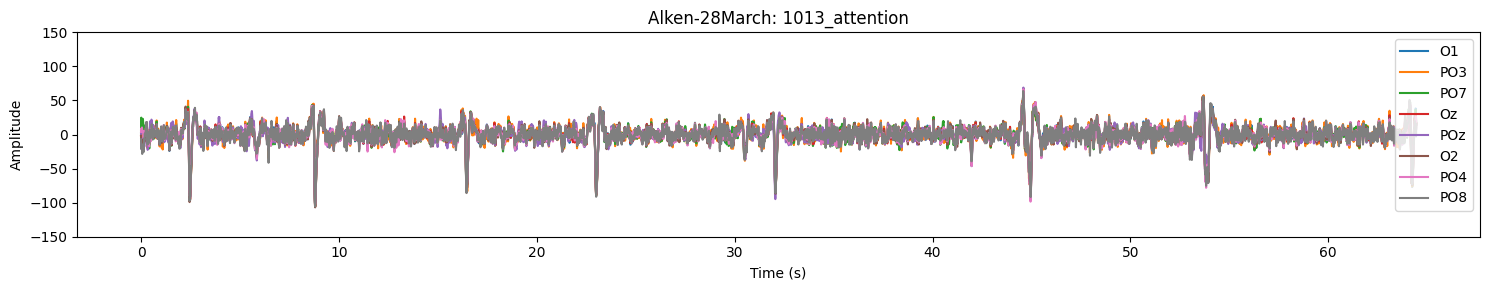

In [18]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=(eeg.title))

In [19]:
# # TODO: automate this. look into the labstreaming layers and the markers
# cut first 5 seconds and last 5 seconds
for eeg in eeg_data:
    eeg.cut_signal(5, 5, cut_to=False)

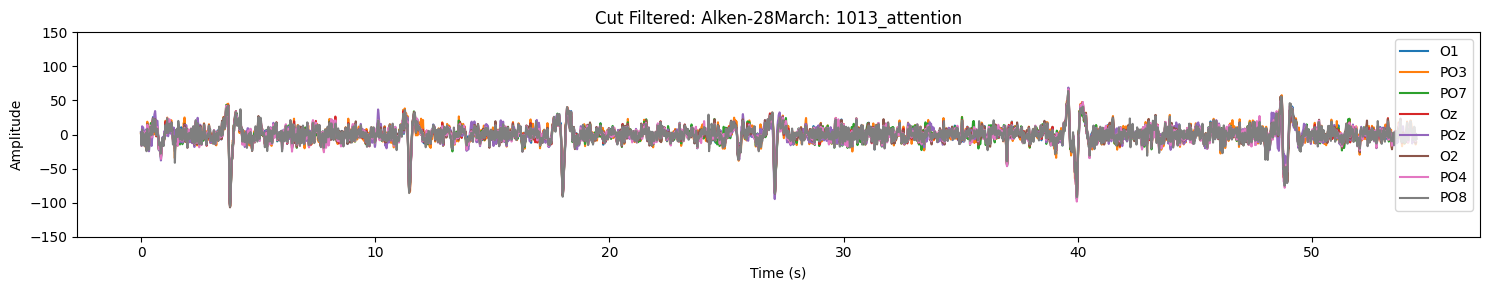

In [20]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("Cut Filtered: "+eeg.title))

In [21]:
psd_plot_interactive(eeg_data, chan_name, nperseg_max=50, nfft_max=50,fig_x=15,fig_y=6)

interactive(children=(IntSlider(value=20, description='nperseg*fs:', max=50, min=1), IntSlider(value=20, descr…

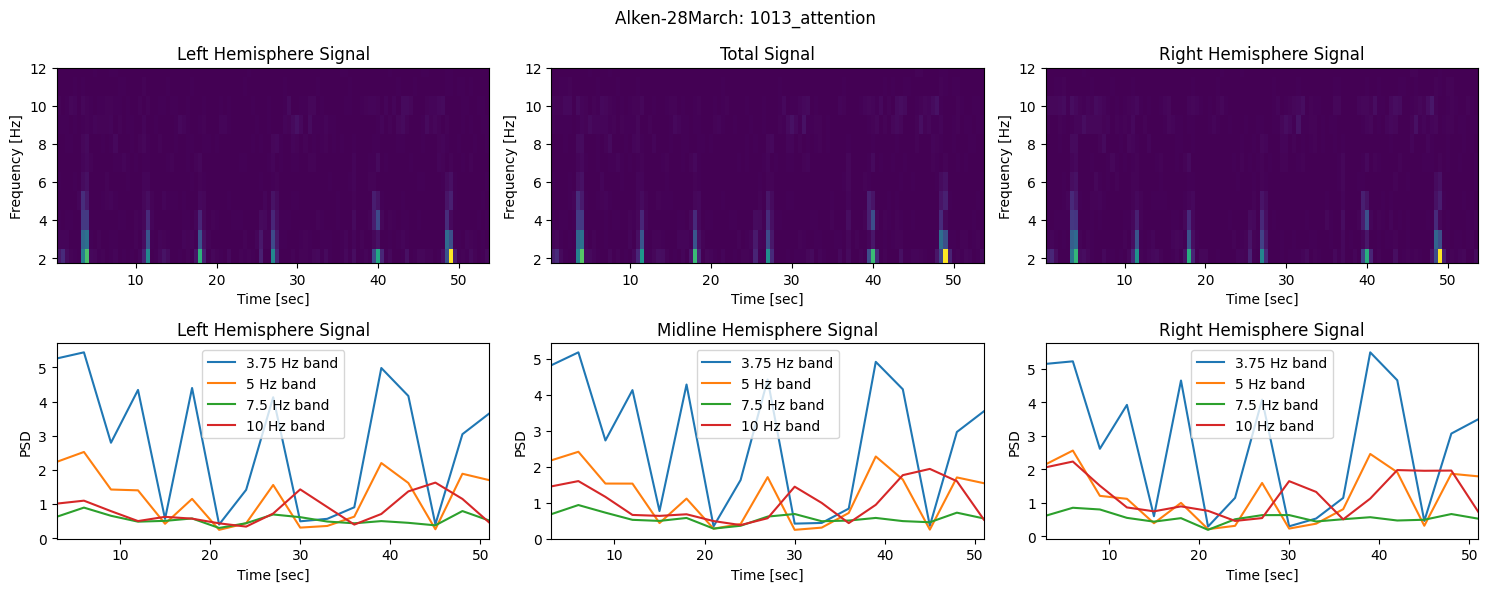

In [22]:
def chan_hemisphere(chan_name):
    # left hemisphere -> odd numbers (1,3,5,7) 
    left_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
    # right hemisphere -> even numbers (2,4,6,8)
    right_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
    # midline -> z
    midline_hemisphere = [chan for chan in chan_name if chan[-1] == 'z']
    return left_hemisphere, midline_hemisphere, right_hemisphere

def hemisphere_signal_avg(eeg, chan_name):
    left_hemisphere, midline_hemisphere, right_hemisphere = chan_hemisphere(chan_name)

    # seperate the signal into left and right hemisphere and take the average per channel
    left_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in left_hemisphere],:], axis=0)
    right_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in right_hemisphere],:], axis=0)
    midline_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in midline_hemisphere],:], axis=0)
    
    return left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal

def plot_spectrogram_and_bands(eeg,title=None, band_freqs=None, f_min=5, f_max=15, fs=250):
    if band_freqs:
        f_min = min(band_freqs) - 2
        f_max = max(band_freqs) + 2
    else:
        band_freqs = [f_min, f_max]
    total_signal = np.mean(eeg.filtered_signal, axis=0)
    left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal = hemisphere_signal_avg(eeg, chan_name)

    def masked_spectogram(singal, nperseg=6,nfft=6):
        frequencies, times, spectrogram = signal.spectrogram(singal, fs=fs, nperseg=fs*nperseg, noverlap=fs*nperseg/2, scaling='spectrum', mode='psd', nfft=fs*nfft)
        mask = (frequencies >= f_min) & (frequencies <= f_max)
        spectrogram_masked = spectrogram[mask, :]
        frequencies_masked = frequencies[mask]
        return frequencies_masked, times, spectrogram_masked
    
    # Plot the spectrogram using matplotlib
    
    # fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    def plot_sepctro(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal, nperseg=1,nfft=1)
        ax.pcolormesh(times, frequencies_masked, spectrogram_masked)
        ax.set_ylim(f_min, f_max)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_title(title)
    
    # plot spectro per each channel in a 2 by 4
    # for i, chan in enumerate(chan_name):
    #     if i < 4:
    #         plot_sepctro(axs[0,i], eeg.filtered_signal[i,:], chan)
    #     else:
    #         plot_sepctro(axs[1,i-4], eeg.filtered_signal[i,:], chan)


    plot_sepctro(axs[0,0], left_hemisphere_signal, 'Left Hemisphere Signal')
    plot_sepctro(axs[0,1], total_signal, 'Total Signal')
    plot_sepctro(axs[0,2], right_hemisphere_signal, 'Right Hemisphere Signal')

    def plot_bands(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal)
        # Plot the PSDs in the frequency bands of interest through time
        for i, band_freq in enumerate(band_freqs):
            band_mask = (frequencies_masked >= band_freq-1) & (frequencies_masked <= band_freq+1)
            psd = np.mean(spectrogram_masked[band_mask, :], axis=0)
            ax.plot(times, psd, label=f'{band_freqs[i]} Hz band')
        ax.set_xlim(times[0], times[-1])
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('PSD')
        ax.legend()
        ax.set_title(title)

    if band_freqs:
        plot_bands(axs[1,0], left_hemisphere_signal, 'Left Hemisphere Signal')
        plot_bands(axs[1,1], midline_hemisphere_signal, 'Midline Hemisphere Signal')
        plot_bands(axs[1,2], right_hemisphere_signal, 'Right Hemisphere Signal')
    
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
for eeg in eeg_data: 
    plot_spectrogram_and_bands(eeg, title = eeg.title, band_freqs=eeg.stimulus_frequency)



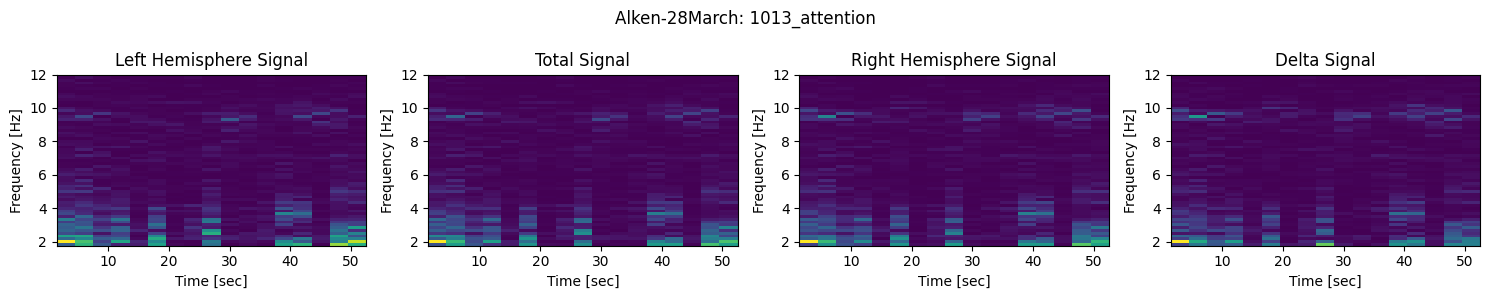

In [23]:
def chan_hemisphere(chan_name):
    # left hemisphere -> odd numbers (1,3,5,7) 
    left_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
    # right hemisphere -> even numbers (2,4,6,8)
    right_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
    # midline -> z
    midline_hemisphere = [chan for chan in chan_name if chan[-1] == 'z']
    return left_hemisphere, midline_hemisphere, right_hemisphere

def hemisphere_signal_avg(eeg, chan_name):
    left_hemisphere, midline_hemisphere, right_hemisphere = chan_hemisphere(chan_name)

    # seperate the signal into left and right hemisphere and take the average per channel
    left_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in left_hemisphere],:], axis=0)
    right_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in right_hemisphere],:], axis=0)
    midline_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in midline_hemisphere],:], axis=0)
    
    return left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal

def plot_spectrogram_and_bands(eeg,title=None, band_freqs=None, f_min=5, f_max=15, fs=250):
    if band_freqs:
        f_min = min(band_freqs) - 2
        f_max = max(band_freqs) + 2
    else:
        band_freqs = [f_min, f_max]
    total_signal = np.mean(eeg.filtered_signal, axis=0)
    left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal = hemisphere_signal_avg(eeg, chan_name)

    def masked_spectogram(singal, nperseg=6,nfft=6):
        frequencies, times, spectrogram = signal.spectrogram(singal, fs=fs, nperseg=fs*nperseg, noverlap=fs*nperseg/2, scaling='spectrum', mode='psd', nfft=fs*nfft)
        mask = (frequencies >= f_min) & (frequencies <= f_max)
        spectrogram_masked = spectrogram[mask, :]
        frequencies_masked = frequencies[mask]
        return frequencies_masked, times, spectrogram_masked
    
    # Plot the spectrogram using matplotlib
    
    # fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 3))
    def plot_sepctro(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal, nperseg=6,nfft=6)
        ax.pcolormesh(times, frequencies_masked, spectrogram_masked)
        ax.set_ylim(f_min, f_max)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_title(title)
    

    plot_sepctro(axs[0], left_hemisphere_signal, 'Left Hemisphere Signal')
    plot_sepctro(axs[1], total_signal, 'Total Signal')
    plot_sepctro(axs[2], right_hemisphere_signal, 'Right Hemisphere Signal')
    plot_sepctro(axs[3], left_hemisphere_signal-right_hemisphere_signal-midline_hemisphere_signal, 'Delta Signal')

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
for eeg in eeg_data: 
    plot_spectrogram_and_bands(eeg, title = eeg.title, band_freqs=eeg.stimulus_frequency)

In [24]:
%%capture 
import mne
# eeg_data = eeg_data[2:]
# get the min stimulus frequency from the eeg data
min_freq = 5
# for eeg in eeg_data:
#     if eeg.stimulus_frequency:
#         if min(eeg.stimulus_frequency) <= min_freq:
#             min_freq = min(eeg.stimulus_frequency) - 2

# get the max stimulus frequency from the eeg data
max_freq = 15
# for eeg in eeg_data:
#     if eeg.stimulus_frequency:
#         if max(eeg.stimulus_frequency) >= max_freq:
#             max_freq = max(eeg.stimulus_frequency)+2

freqs = np.arange(min_freq, max_freq, .3)
n_cycles = freqs
t_min, t_max = 1, 6

# Get the class names
class_names = [eeg.title for eeg in eeg_data]

times = np.linspace(t_min, t_max, eeg_data[0].epoch_signal.shape[2])

# compute power for each epoch
power = []
for eeg in eeg_data:
    power.append(mne.time_frequency.tfr_array_morlet(eeg.epoch_signal, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power'))

power_stack = np.stack(power)

for pow in power:
    mne.baseline.rescale(pow, times, (None, times[0]), mode='mean', copy=False)
    
power = power_stack

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

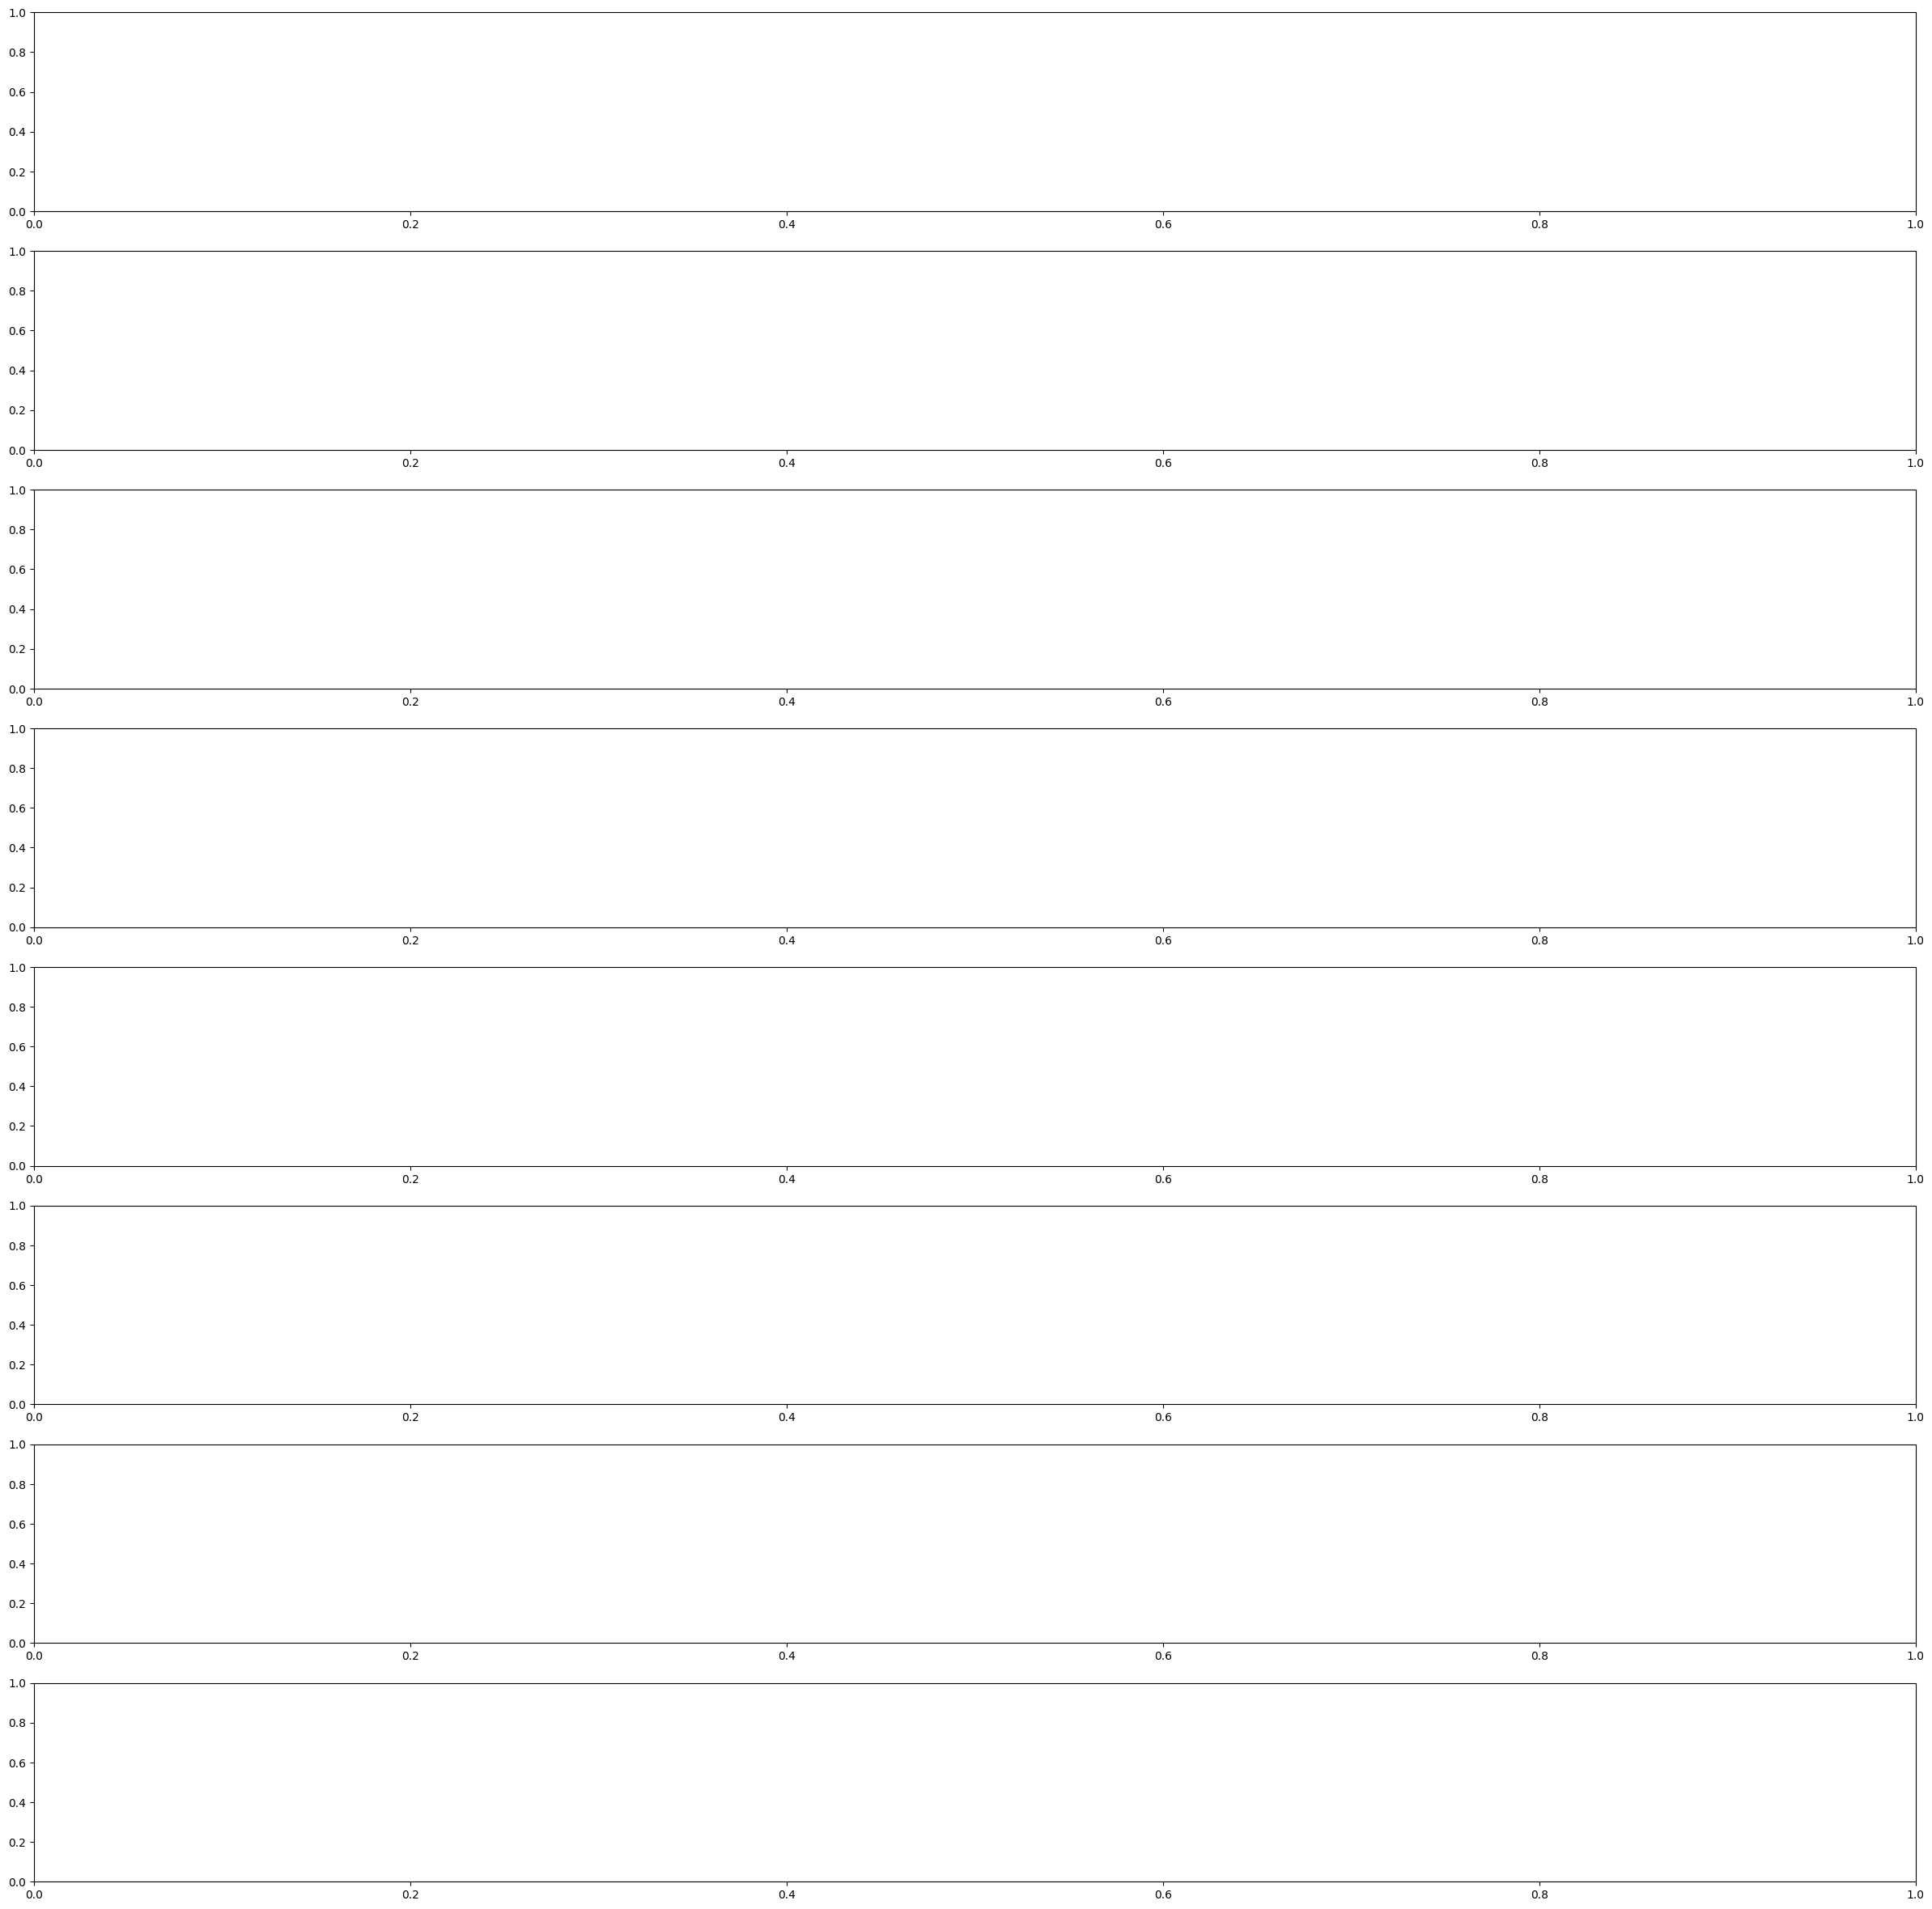

In [25]:
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(len(chan_name), len(class_names), figsize=(30, 30))
for j in range(len(class_names)):
    for i in range(len(chan_name)):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
        if eeg_data[j].stimulus_frequency:
            for freq in eeg_data[j].stimulus_frequency:
                ax[i, j].axhline(y=freq, linestyle='--', color='white')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()